In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [3]:
train_cifar = torchvision.datasets.CIFAR10(root =".",train = True,transform=transforms.ToTensor(),download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 45385423.86it/s]


Extracting ./cifar-10-python.tar.gz to .


In [4]:
test_cifar = torchvision.datasets.CIFAR10(root=".",train = False,transform = transforms.ToTensor(), download = True)

Files already downloaded and verified


In [5]:
test_cifar.data.shape

(10000, 32, 32, 3)

In [6]:
train_cifar.data.shape

(50000, 32, 32, 3)

In [7]:
max(train_cifar.targets)

9

In [8]:
#Dataloaders

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_cifar, batch_size = batch_size, shuffle = True )
test_loader = torch.utils.data.DataLoader(dataset = test_cifar,batch_size = batch_size,shuffle = False)

In [9]:
#model Building

class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()


    self.conv = nn.Sequential( nn.Conv2d(in_channels = 3, out_channels=32, kernel_size = 3, stride = 2),
                               nn.ReLU(),
                               nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size = 3, stride = 2),
                               nn.ReLU(),
                               nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, stride = 2),
                               nn.ReLU()
        
                              )
    
    self.fc1 = nn.Linear(128*3*3,1024)
    self.fc2 = nn.Linear(1024,10)

  def forward(self,x):

    out = self.conv(x)
    out = out.view(-1,128*3*3)
    out = F.dropout(out,p=0.5)
    out = self.fc1(out)
    out = F.relu(out)
    out = F.dropout(out,p=0.2)
    out = self.fc2(out)
    
    return out


In [10]:
model = CNN()

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
#training

epochs = 15
train_loss = np.zeros(epochs)
test_loss = np.zeros(epochs)

for i in range(epochs):
  

  model.train()
  train_losses = []
  for inputs,targets in train_loader:

    inputs,targets = inputs.to(device), targets.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss_train = criterion(outputs,targets)

    loss_train.backward()

    optimizer.step()

    train_losses.append(loss_train.item())

  train_losses = np.mean(train_losses)

  train_loss[i] = train_losses

  model.eval()
  test_losses = []

  for inputs,targets in test_loader:

    inputs, targets = inputs.to(device),targets.to(device)

    outputs = model(inputs)

    loss_test = criterion(outputs,targets)

    test_losses.append(loss_test.item())
  
  test_losses = np.mean(test_losses)

  test_loss[i] = test_losses


  print(f"epoch -- 1/{i+1} , training loss -- {train_losses} ,  test loss -- {test_losses}")



epoch -- 1/1 , training loss -- 1.7068761553605805 ,  test loss -- 1.5445921556859077
epoch -- 1/2 , training loss -- 1.4368704130582493 ,  test loss -- 1.364397939247421
epoch -- 1/3 , training loss -- 1.315436947071339 ,  test loss -- 1.275931620899635
epoch -- 1/4 , training loss -- 1.2277789265298478 ,  test loss -- 1.2098116572899154
epoch -- 1/5 , training loss -- 1.149961213321637 ,  test loss -- 1.1493609773961804
epoch -- 1/6 , training loss -- 1.0888008460059495 ,  test loss -- 1.1469265629973593
epoch -- 1/7 , training loss -- 1.0415856711699834 ,  test loss -- 1.1138203189342837
epoch -- 1/8 , training loss -- 0.9975210239210397 ,  test loss -- 1.098614522927924
epoch -- 1/9 , training loss -- 0.9498736641900923 ,  test loss -- 1.0819347470621519
epoch -- 1/10 , training loss -- 0.9171256015977591 ,  test loss -- 1.0869677972189988
epoch -- 1/11 , training loss -- 0.8835009679465038 ,  test loss -- 1.0510681173469447
epoch -- 1/12 , training loss -- 0.8527702317213464 ,  te

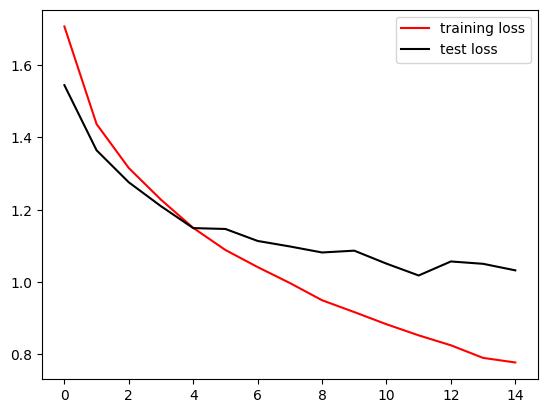

In [15]:
plt.plot(train_loss,label = "training loss", c = "r")
plt.plot(test_loss,label = "test loss", c = "black")
plt.legend()
plt.show()

In [16]:
model.eval()

n_correct = 0
n_total = 0 

for inputs,targets in train_loader:

  inputs,targets = inputs.to(device),targets.to(device)

  outputs = model(inputs)

  _ , preds = torch.max(outputs,1)

  n_correct += (preds==targets).cpu().numpy().sum()

  n_total += len(targets)


train_acc = n_correct/n_total




n_correct = 0 
n_total = 0
for inputs,targets in test_loader:

  inputs,targets = inputs.to(device),targets.to(device)

  outputs = model(inputs)

  _, preds = torch.max(outputs,1)

  n_correct += (preds==targets).cpu().numpy().sum()

  n_total += len(targets)

test_acc = n_correct/n_total


print(f"training accuracy -- {train_acc} , test accuracy -- {test_acc}")

training accuracy -- 0.73736 , test accuracy -- 0.645


In [18]:
test_loader = torch.utils.data.DataLoader(dataset = test_cifar, batch_size = 10000,shuffle = False)

In [20]:
#Visualizing the results

for inputs, targets in test_loader:

  inputs= inputs.to(device)
  targets = targets.to(device)



  outputs = model(inputs)

  _,preds = torch.max(outputs,1)

In [21]:
targets = targets.cpu().numpy()
preds = preds.cpu().numpy()

In [23]:
idx = np.where(targets!=preds)

In [24]:
len(idx[0])

3540

prediction 8
target 2


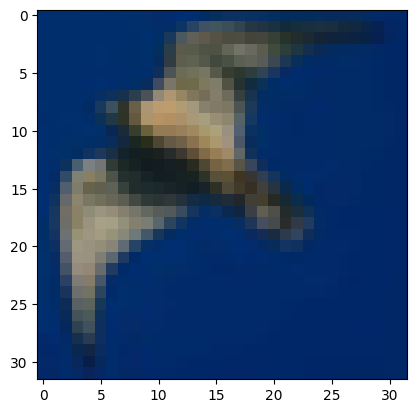

In [26]:
mis_idx = np.random.choice(idx[0])

print("prediction",preds[mis_idx])
print("target",targets[mis_idx])
plt.imshow(test_cifar.data[mis_idx])
plt.show()